In [1]:
"""
Multi-Condition Frame Extraction and Inter-chain Base-base Interaction Analysis Script for Submission

Author: QIN ZHANG
Created: 2025-06-11
Last Modified: 2025-06-11
License: MIT License

This script extracts specific frames from MD trajectories, calculates inter-chain base-base distances,
and generates contour plots for 5xG4C2 system to analyze RNA base-base interactions under varying salt conditions.
"""

# Cell 1 (Multi-Condition Frame Extraction)
import MDAnalysis as mda
import os
"""
Define paths to simulation data for different salt conditions.
Data source: Zenodo repository (DOI: 10.5281/zenodo.15608685)
"""
conditions = {
    "neutral":   "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_Na_neutral/lake_10us/",
    "17mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/",
    "35mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/",
    "70mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/",
    "139mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/",
    "278mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/",
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/",
    "696mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/"
}

subfolders = ["C1", "C2", "C3", "C4"] # Simulation replicas

for cond_name, parent_dir in conditions.items():
    local_counter = 1
    for subfolder in subfolders:
        tpr_file = os.path.join(parent_dir, subfolder, "RNA.gro")
        xtc_file = os.path.join(parent_dir, subfolder, "RNA_clusterRNA.xtc")

        # Skip if input files are missing
        if not os.path.isfile(tpr_file) or not os.path.isfile(xtc_file):
            print(f"Skipping {cond_name}/{subfolder}: Missing files")
            continue
            
        try:
            u = mda.Universe(tpr_file, xtc_file)
        except Exception as e:
            print(f"Error in {cond_name}/{subfolder}: {e}")
            continue
            
        # Extract frames from 5000 to 10000 with step 50, limit to 100 frames
        frames_to_extract = list(range(5000, 10000, 50))[:100]
        valid_frames = [f for f in frames_to_extract if f < len(u.trajectory)]

        # Write selected frames to GRO files
        for frame in valid_frames:
            u.trajectory[frame]
            output_gro = os.path.join(parent_dir, f"{local_counter}.gro")
            u.atoms.write(output_gro)
            local_counter += 1

print("All conditions processed!")

All conditions processed!


In [2]:
##Cell 2 (Chain Distance Calculation - Unchanged)
import MDAnalysis as mda
from MDAnalysis.analysis import distances

def calculate_chain_distances(bead_name, u):
    """
    Calculate inter-chain distances for all chain pairs in the system.
    
    Parameters:
        bead_name (str): Name of beads to use for distance calculation (e.g., 'SC3', 'SC7')
        u (MDAnalysis.Universe): MDAnalysis Universe object
        
    Returns:
        dict: Dictionary of inter-chain distances, keyed by "chain_i_chain_j"
    """
    # Define chain selections for 5xG4C2 system (12 chains total)
    chains = {
        "ch1": f'index 0 to 359 and name {bead_name}',
        "ch2": f'index 360 to 719 and name {bead_name}',
        "ch3": f'index 720 to 1079 and name {bead_name}',
        "ch4": f'index 1080 to 1439 and name {bead_name}',
        "ch5": f'index 1440 to 1799 and name {bead_name}',
        "ch6": f'index 1800 to 2159 and name {bead_name}',
        "ch7": f'index 2160 to 2519 and name {bead_name}',
        "ch8": f'index 2520 to 2879 and name {bead_name}',
        "ch9": f'index 2880 to 3239 and name {bead_name}',
        "ch10": f'index 3240 to 3599 and name {bead_name}',
        "ch11": f'index 3600 to 3959 and name {bead_name}',
        "ch12": f'index 3960 to 4319 and name {bead_name}'
    }

    distance_data = {}
    for name_i, sel_i in chains.items():
        chain_i = u.select_atoms(sel_i)
        for name_j, sel_j in chains.items():
            if name_i == name_j: continue # Skip intra-chain distances
            chain_j = u.select_atoms(sel_j)
            # Calculate all-against-all distances with periodic boundary conditions
            dist_arr = distances.distance_array(chain_i.positions, chain_j.positions, box=u.dimensions)
            distance_data[f"{name_i}_{name_j}"] = dist_arr
    return distance_data

In [3]:
##Cell 3 (Multi-Condition Data Loading)
import MDAnalysis as mda
import os

condition_data = {} # Store processed data for each condition

for cond_name, parent_dir in conditions.items():
    sc3_data = []  # SC3 bead distance data
    sc7_data = []  # SC7 bead distance data
    for i in range(1, 401):
        gro_file = os.path.join(parent_dir, f"{i}.gro")
        if not os.path.exists(gro_file):
            print(f"Missing {cond_name} file {i}")
            continue
            
        u = mda.Universe(gro_file)
        sc3_data.append(calculate_chain_distances('SC3', u))
        sc7_data.append(calculate_chain_distances('SC7', u))
    
    condition_data[cond_name] = (sc3_data, sc7_data) # Store both bead types

print("All data loaded!")

All data loaded!


In [4]:
###Cell 4 (Multi-Condition Data Processing)
import numpy as np
import pickle

cutoff1, cutoff2 = 6, 10  # Distance cutoffs for filtering (Å)
filtered_conditions = {}

for cond_name, (sc3_data, sc7_data) in condition_data.items():
    filtered = []
    for s3, s7 in zip(sc3_data, sc7_data):
        # Flatten all inter-chain distances
        x = np.concatenate([v.flatten() for v in s3.values()])
        y = np.concatenate([v.flatten() for v in s7.values()])
        # Apply distance filters
        mask = (x < cutoff1) & (y < cutoff2)
        filtered.append((x[mask], y[mask]))

    # Save filtered data for future use
    output_path = os.path.join(conditions[cond_name], "5xfiltered_610Adata.pkl")
    with open(output_path, "wb") as f:
        pickle.dump(filtered, f)
    
    filtered_conditions[cond_name] = filtered

print("All data processed and saved!")

All data processed and saved!


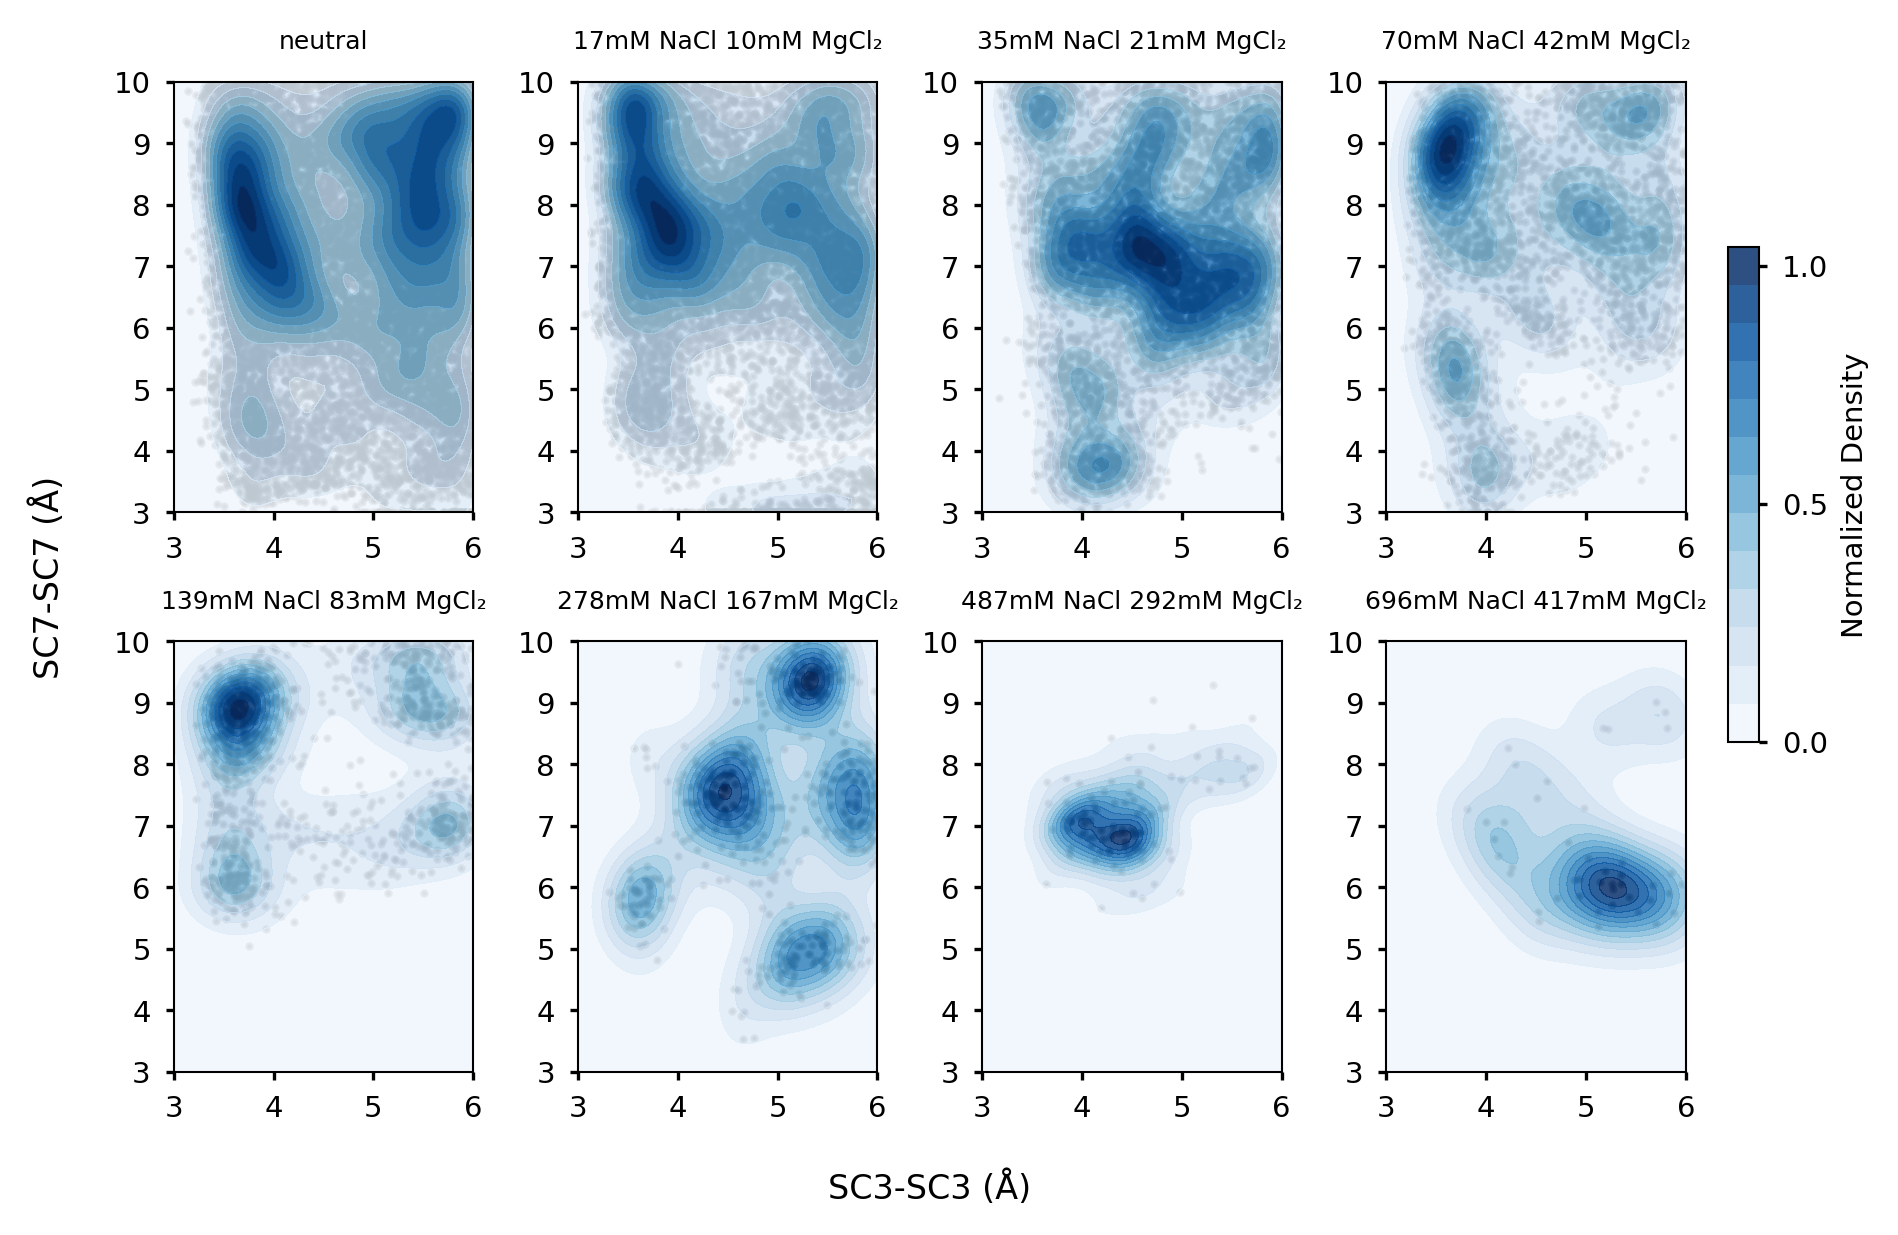

In [3]:
# Cell 5 (Contour Plot Generation)
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import os
import pickle
from matplotlib import cm
from matplotlib.colors import Normalize


# Configure plot style for publication
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 7,
    'axes.linewidth': 0.5,
    'figure.dpi': 300,  
    'contour.linewidth': 0.5  
})

conditions = {
    "neutral":   "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_Na_neutral/lake_10us/",
    "17mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/",
    "35mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/",
    "70mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/",
    "139mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/",
    "278mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/",
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/",
    "696mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/"
}
ordered_conditions = ["neutral", "17mMNaCl", "35mMNaCl", "70mMNaCl", "139mMNaCl", "278mMNaCl", "487mMNaCl", "696mMNaCl"]
ordered_title = [
    # Remaining titles follow salt concentration conversions"neutral", "17mM NaCl 10mM MgCl₂", 
    "neutral", 
    "17mM NaCl 10mM MgCl₂", 
    "35mM NaCl 21mM MgCl₂", 
    "70mM NaCl 42mM MgCl₂", 
    "139mM NaCl 83mM MgCl₂", 
    "278mM NaCl 167mM MgCl₂", 
    "487mM NaCl 292mM MgCl₂", 
    "696mM NaCl 417mM MgCl₂"
]
# Create figure with optimized grid layout for ACS two-column format
fig = plt.figure(figsize=(7, 5.5))   # 7" width matches ACS two-column limit
main_gs = fig.add_gridspec(2, 4, left=0.10, right=0.82,  bottom=0.15, top=0.75,wspace=0.35, hspace=0.3)
axs = main_gs.subplots()

# Set global plotting parameters
GLOBAL_CMAP = 'Blues'
GLOBAL_NORM = Normalize(vmin=0, vmax=1)
all_cfs = []  # Collect contour plots for shared colorbar

# Main plotting loop for each condition
for idx, cond in enumerate(ordered_conditions):
    ax = axs.flat[idx]
    
    # Load filtered distance data
    with open(os.path.join(conditions[cond], "5xfiltered_610Adata.pkl"), "rb") as f:
        data = pickle.load(f)
    x = np.concatenate([d[0] for d in data])
    y = np.concatenate([d[1] for d in data])

    # Clip distances to valid ranges for plotting
    x = np.clip(x, 3.0, 6)
    y = np.clip(y, 3.0, 10)

    # Compute 2D kernel density estimate
    kde = gaussian_kde(np.vstack([x, y]))
    X, Y = np.mgrid[3:6:100j, 3:10:100j]
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
    Z_normalized = Z / Z.max() # Normalize density
    
    # Plot scatter and contour
    ax.scatter(x, y, s=1, alpha=0.2, c='black', rasterized=True)
    cf = ax.contourf(X, Y, Z_normalized, levels=12,
                    cmap=GLOBAL_CMAP, norm=GLOBAL_NORM, alpha=0.85)
    all_cfs.append(cf)
    
    # Configure subplot
    ax.set_title(ordered_title[idx], loc='center', fontsize=6, pad=8)
    ax.tick_params(axis='both', which='both', length=2)  # Increased tick length

# Add shared colorbar
cax = fig.add_axes([0.84, 0.35, 0.015, 0.3])  # Positioned for 7" width
cbar = fig.colorbar(all_cfs[0], cax=cax)
cbar.set_ticks([0, 0.5, 1.0])
cbar.ax.tick_params(labelsize=7, length=2)
cbar.set_label('Normalized Density', fontsize=7, labelpad=3)

# Add shared axis labels
fig.text(x=0.46, y=0.08,  # Centered under bottom row
        s='SC3-SC3 (Å)', ha='center', va='center',fontsize=8)

fig.text(x=0.04, y=0.45,  # Centered along left edge
        s='SC7-SC7 (Å)', rotation=90,ha='center', va='center',fontsize=8)

# ==== Save with Journal Specifications ====
plt.savefig('FigureS6b.png', dpi=300, bbox_inches='tight')
plt.show()